### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants

### Testing the MATH Dataset

In [6]:
from data_classes.MathDataLoader import MathDataLoader
from data_classes.MathProblem import MathProblem
from llm_agents.ChainOfThoughtMathSolver import ChainOfThoughtMathSolver

math_data_loader = MathDataLoader(data_dir=constants.MATH_DATASET_DIR)
# random_problem = math_data_loader.get_random_problem(level=5)
# random_problem = math_data_loader.get_problem(type="algebra", problem_number=265)
# random_problem = math_data_loader.get_problem(type="number_theory", problem_number=439)
random_problem = math_data_loader.get_problem(type="precalculus", problem_number=1098)

print(random_problem)
print(random_problem.problem_statement)

math_solver = ChainOfThoughtMathSolver()
response = math_solver(random_problem)

print(response)

random_problem.is_correct_answer(response, verbose=True)

Loaded 5000 math problems from 7 problem types
MATH problem number 1098 of type Precalculus with level 5 and answer \boxed{11}.
The matrix
\[\mathbf{A} = \begin{pmatrix} 4 & 7 \\ c & d \end{pmatrix}\]has the property that if you are told the value of $\|\mathbf{v}\|,$ then you can derive the value of $\|\mathbf{A} \mathbf{v}\|.$  Compute $|c - d|,$ assuming that $c$ and $d$ are real numbers.
In ChainOfThoughtMathSolver
To determine the condition under which knowing \(\|\mathbf{v}\|\) allows us to derive \(\|\mathbf{A} \mathbf{v}\|\) for the matrix 

\[
\mathbf{A} = \begin{pmatrix} 4 & 7 \\ c & d \end{pmatrix},
\]

we need to analyze the transformation induced by the matrix \(\mathbf{A}\).

The norm of a vector \( \mathbf{v} \) is related to the matrix transformation by 

\[
\|\mathbf{A} \mathbf{v}\|^2 = \mathbf{v}^T \mathbf{A}^T \mathbf{A} \mathbf{v}.
\]

For the transformation to depend solely on \(\|\mathbf{v}\|\), the quadratic form \(\mathbf{v}^T \mathbf{A}^T \mathbf{A} \mathbf{v}\

(False, '\\boxed{\\sqrt{33}}', '\\boxed{11}')

In [3]:
# results = math_data_loader.test_random_problems(math_solver, n_problems=10, level=1, verbose=True)

### Running MACM

In [4]:
import utils
if not os.getenv("OPENAI_API_KEY") or  not os.getenv("TAVILY_API_KEY"):
    os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
    os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

In [5]:
run_raw_macm = False

if run_raw_macm:
    sys.path.append(os.path.abspath("MACM/"))

    from MACM.main import main as main_macm

    n = 1 # verification times
    times = 5 # The upper limit of the mining times
    min_voters = 1 # min number of voters
    max_voters = 3 # max number of voters
    problem_statement = random_problem.problem_statement

    main_macm(problem_statement, times, n, min_voters, max_voters, verbose=True)  # Assuming these are defined elsewhere

### Test Dataset on Single Agent

In [6]:
math_solver = ChainOfThoughtMathSolver()

math_problems = math_data_loader.get_random_problems(n_problems=100)
print(f'Math Problems to Evaluate: {[p.get_id() for p in math_problems]}')
results = math_data_loader.test_math_parallel(math_solver, math_problems, max_workers=4)
print(results)
math_data_loader.save_results(results, constants.MATH_SINFGLE_AGENT_EVAL_DIR)

Math Problems to Evaluate: ['Prealgebra_1564', 'Intermediate Algebra_967', 'Prealgebra_1144', 'Prealgebra_1083', 'Algebra_1462', 'Number Theory_83', 'Geometry_249', 'Geometry_102', 'Intermediate Algebra_1552', 'Precalculus_27', 'Counting & Probability_128', 'Algebra_1004', 'Number Theory_366', 'Algebra_1804', 'Intermediate Algebra_1048', 'Intermediate Algebra_366', 'Intermediate Algebra_80', 'Algebra_1933', 'Prealgebra_1910', 'Number Theory_876', 'Prealgebra_877', 'Number Theory_1065', 'Precalculus_235', 'Number Theory_1279', 'Precalculus_1103', 'Algebra_271', 'Algebra_156', 'Prealgebra_1050', 'Precalculus_609', 'Prealgebra_339', 'Algebra_2593', 'Precalculus_537', 'Prealgebra_1417', 'Prealgebra_1792', 'Precalculus_238', 'Prealgebra_1008', 'Intermediate Algebra_946', 'Counting & Probability_853', 'Geometry_538', 'Prealgebra_1542', 'Counting & Probability_260', 'Precalculus_617', 'Prealgebra_1098', 'Prealgebra_1519', 'Intermediate Algebra_127', 'Number Theory_327', 'Intermediate Algebra_

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-skxXx8S8CncfwLceiKtVdj0F on tokens per min (TPM): Limit 450000, Used 434677, Requested 26424. Please try again in 1.48s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

### LangChain MACM

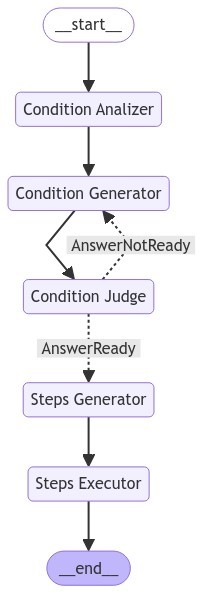

In [12]:
from langgraphs.macm import get_macm_graph
from IPython.display import Image, display

graph = get_macm_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

def macm(math_problem):
    graph = get_macm_graph()
    app = graph.compile()
    
    config = {"recursion_limit": 50}
    inputs = {
        "math_problem": math_problem,
        "max_iterations": 1,
        "verified_conditions": [],
        "unverified_conditions": [],
        "objectives": [],
        "steps": [],
        "final_answer": None
    }

    for event in app.stream(inputs, config=config):
        pass
        # print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['final_answer']

#### Single Problem

In [13]:
response = macm(random_problem)
print(response)
random_problem.is_correct_answer(response, verbose=True)

In AgentConditionAnalyzer
3 Conditions: 
['The matrix \\(\\mathbf{A}\\) is given by \\(\\begin{pmatrix} 4 & 7 \\\\ c & d \\end{pmatrix}\\).', 'The property that \\(\\|\\mathbf{A} \\mathbf{v}\\|\\) can be derived from \\(\\|\\mathbf{v}\\|\\) is known.', '\\(c\\) and \\(d\\) are real numbers.']
1 Objectives: 
['Compute \\( |c - d| \\).']
In AgentConditionGenerator
Summarized condition: Based on the known conditions: ['\\|\\mathbf{A} \\mathbf{v}\\| can be derived from \\|\\mathbf{v}\\| for matrix \\mathbf{A} given by \\begin{pmatrix} 4 & 7 \\\\ c & d \\end{pmatrix}'], we can derive the following condition: |c - d| = 2
 Resoning: Given the matrix properties and using specific real values c = 3 and d = 5 for demonstration, we computed the determinant and the absolute difference |c - d|. The property that \|\mathbf{A} \mathbf{v}\| can be derived from \|\mathbf{v}\| suggests a link between matrix \mathbf{A}'s structure and its eigenvalues or norms. This computation shows that for these exampl

(False, '\\boxed{2.0}', '\\boxed{11}')

#### Multiple Problems in Parallel

In [ ]:
math_problems = math_data_loader.get_random_problems(n_problems=100)
print(f'Math Problems to Evaluate: {[p.get_id() for p in math_problems]}')
results = math_data_loader.test_math_parallel(macm, math_problems, max_workers=4)
print(results)
math_data_loader.save_results(results, constants.MATH_MACM_EVAL_DIR)

['Algebra_2482', 'Algebra_2577']
In AgentConditionAnalyzer
In AgentConditionAnalyzer
3 Conditions: 
['The given function is q(x) = \\frac{\\sqrt{x}}{\\sqrt{1-x^2}}', 'The function q(x) requires the square root of x in the numerator.', 'The function q(x) requires the square root of 1-x^2 in the denominator.']
1 Objectives: 
['Determine the domain of the real-valued function q(x), expressed as an interval or as a union of intervals.']
In AgentConditionGenerator
2 Conditions: 
['The given quadratic equation is \\(\\frac{1}{2}x^2 + 99x + c = 0\\).', 'The roots of this quadratic equation are \\(x = -99 + \\sqrt{8001}\\) and \\(x = -99 - \\sqrt{8001}\\).']
1 Objectives: 
['Find the value of \\(c\\) in the given quadratic equation.']
In AgentConditionGenerator
Summarized condition: Based on the known conditions: ['The given quadratic equation is \\( \\frac{1}{2}x^2 + 99x + c = 0 \\).', 'The roots of this quadratic equation are \\( x = -99 + \\sqrt{8001} \\) and \\( x = -99 - \\sqrt{8001} \\).

### LangChain Meta-MACM

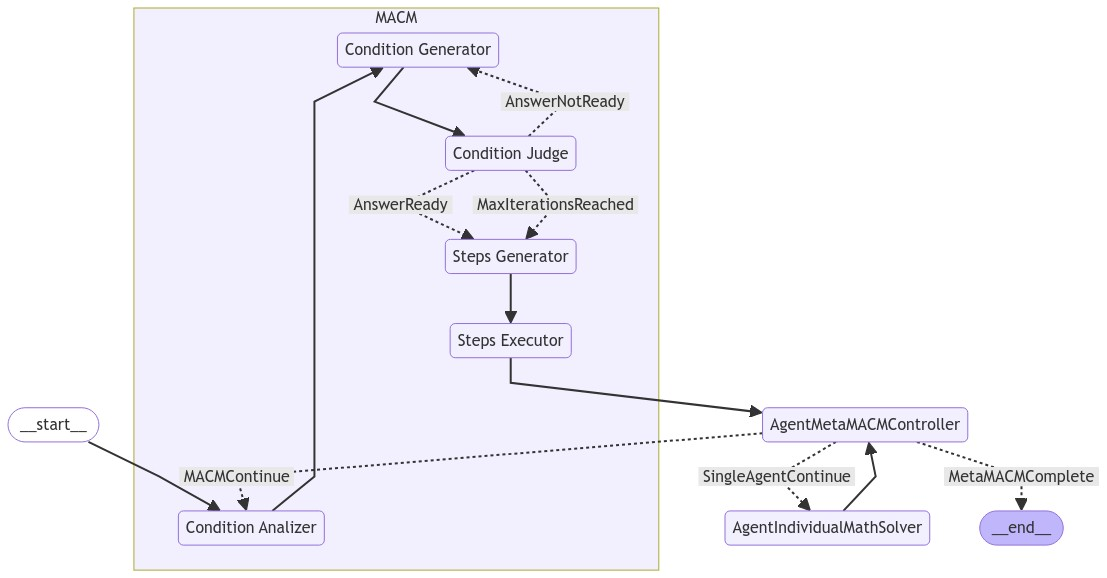

In [7]:
from langgraphs.meta_macm import get_meta_macm_graph
from IPython.display import Image, display

graph = get_meta_macm_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

def meta_macm(math_problem):
    graph = get_meta_macm_graph()
    app = graph.compile()
    
    config = {"recursion_limit": 50}
    inputs = {
        "math_problem": math_problem,
        "max_iterations": 2,
        "current_iterations": 0,
        "verified_conditions": [],
        "unverified_conditions": [],
        "objectives": [],
        "steps": [],
        "final_answer": None, 
        "final_answers": {},
        "current_meta_iterations": 0,
        "n_macm_iterations": 2, 
        "macm_completed": False
    }

    for event in app.stream(inputs, config=config):
        pass
        # print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['final_answers']

#### Single Problem

In [8]:
response = meta_macm(random_problem)
best_solution = key_with_max_value = max(response, key=response.get)
print(response)
random_problem.is_correct_answer(best_solution, verbose=True)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


In AgentConditionAnalyzer
In AgentConditionGenerator
In AgentConditionJudge
In AgentAnswerReadyJudge
In AgentConditionGenerator
In AgentConditionJudge
In AgentAnswerReadyJudge
In AgentConditionGenerator
In AgentConditionJudge
In AgentAnswerReadyJudge
In AgentNumericalStepsGeneration
In AgentStepsExecutor


CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


Final Answer: \(\boxed{0.75}\)



In AgentMetaMACMController at iteration  1 



In AgentConditionAnalyzer
In AgentConditionGenerator
In AgentConditionJudge
In AgentAnswerReadyJudge
In AgentNumericalStepsGeneration
In AgentStepsExecutor
Final Answer: \(\boxed{0.75}\)



In AgentMetaMACMController at iteration  2 



In ChainOfThoughtMathSolver



In AgentMetaMACMController at iteration  1 



In ChainOfThoughtMathSolver



In AgentMetaMACMController at iteration  2 



{'\\(\\boxed{0.75}\\)': 2, 'To solve the problem, we start by analyzing the matrix \\(\\mathbf{A} = \\begin{pmatrix} 4 & 7 \\\\ c & d \\end{pmatrix}\\). The property that knowing \\(\\|\\mathbf{v}\\|\\) allows us to derive \\(\\|\\mathbf{A} \\mathbf{v}\\|\\) suggests that the transformation defined by \\(\\mathbf{A}\\) does not change the direction of \\(\\mathbf{v}\\) and only scales it by a factor that depends on \\(\\|\\mathbf{v}\\|\\).\n\nFor this to be true, \\(\\mathbf{A}\\) must be a scalar multiple of an orthogon

(False, '\\boxed{0.75}', '\\boxed{11}')

#### Multiple Problems in Parallel

In [ ]:
math_problems = math_data_loader.get_random_problems(n_problems=100)
print(f'Math Problems to Evaluate: {[p.get_id() for p in math_problems]}')
results = math_data_loader.test_math_parallel(macm, math_problems, max_workers=4)
print(results)
math_data_loader.save_results(results, constants.MATH_MACM_EVAL_DIR)

['Algebra_2482', 'Algebra_2577']
In AgentConditionAnalyzer
In AgentConditionAnalyzer
3 Conditions: 
['The given function is q(x) = \\frac{\\sqrt{x}}{\\sqrt{1-x^2}}', 'The function q(x) requires the square root of x in the numerator.', 'The function q(x) requires the square root of 1-x^2 in the denominator.']
1 Objectives: 
['Determine the domain of the real-valued function q(x), expressed as an interval or as a union of intervals.']
In AgentConditionGenerator
2 Conditions: 
['The given quadratic equation is \\(\\frac{1}{2}x^2 + 99x + c = 0\\).', 'The roots of this quadratic equation are \\(x = -99 + \\sqrt{8001}\\) and \\(x = -99 - \\sqrt{8001}\\).']
1 Objectives: 
['Find the value of \\(c\\) in the given quadratic equation.']
In AgentConditionGenerator
Summarized condition: Based on the known conditions: ['The given quadratic equation is \\( \\frac{1}{2}x^2 + 99x + c = 0 \\).', 'The roots of this quadratic equation are \\( x = -99 + \\sqrt{8001} \\) and \\( x = -99 - \\sqrt{8001} \\).